In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install "tensorflow-text>=2.11"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 84.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 82.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 43.1 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard
    Fou

In [ ]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.0 MB/s eta 0:00:00


In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.5 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset

In [ ]:
import numpy as np

In [ ]:
import typing
from typing import Any, Tuple

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

In [ ]:
data = load_dataset("aslg_pc12")

Generating train split:   0%|          | 0/87710 [00:00<?, ? examples/s]

Dataset aslg_pc12 downloaded and prepared to /root/.cache/huggingface/datasets/aslg_pc12/default/0.0.1/7ae5d117644e44ff4d2233f27f1d5df93f429efab7b2ea84828516fcbce48fb4. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
df=data["train"].to_pandas()

In [ ]:
df=df.drop_duplicates(subset=['gloss'])

In [ ]:
df.iloc[40:50,:]

,gloss,text
49,SIT BE DESC-CLOSE AT 1 DESC-P.M.\n,the sitting was closed at 1 p.m. \n
52,REQUEST FOR DEFENSE DESC-PARLIAMENTARY IMMUNIT...,request for the defence of parliamentary immun...
53,APPOINTMENT TO COMMITTEE PROPOSAL BY CONFERENC...,appointments to committees proposal by the con...
57,DESC-ORAL QUESTION AND WRITE STATEMENT TABLE S...,oral questions and written statements tabling ...
58,WRITE STATEMENT RULE 116 SEE MINUTE\n,written statements rule 116 see minutes\n
59,AGENDA SEE MINUTE\n,agenda see minutes\n
60,APPOINTMENT TO DESC-PARLIAMENTARY COMMITTEE VO...,appointments to parliamentary committees vote ...
61,VOTE TIME\n,voting time\n
64,SIT BE DESC-CLOSE AT 12 MIDNIGHT\n,the sitting was closed at 12 midnight \n
66,SIT BE DESC-OPEN AT 09.05\n,the sitting was opened at 09.05 \n


In [ ]:
glosses = list(map(lambda s: s.strip(), data["train"]["gloss"]))

In [ ]:
glosses[0] = "MEMBERSHIP PARLIAMENT SEE MINUTE"

In [ ]:
glosses = np.array(glosses)

In [ ]:
glosses

array(['MEMBERSHIP PARLIAMENT SEE MINUTE',
       'APPROVAL MINUTE DESC-PREVIOUS SIT SEE MINUTE',
       'MEMBERSHIP PARLIAMENT SEE MINUTE', ..., 'NAME YOU WHAT(wh)',
       'EAT APPLE', 'EAT ORANGE'], dtype='<U313')

In [ ]:
english = list(map(lambda s: s.strip(), data["train"]["text"]))

In [ ]:
english[0] = "membership of parliament see minutes"

In [ ]:
english = np.array(english)

In [ ]:
english

array(['membership of parliament see minutes',
       'approval of minutes of previous sitting see minutes',
       'membership of parliament see minutes', ..., "What's your name ?",
       'I eat an apple', 'I eat an orange'], dtype='<U323')

In [ ]:
#@title
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

In [ ]:
processed_asl_raw = glosses
english_raw = english

In [ ]:
processed_asl_raw

array(['MEMBERSHIP PARLIAMENT SEE MINUTE',
       'APPROVAL MINUTE DESC-PREVIOUS SIT SEE MINUTE',
       'MEMBERSHIP PARLIAMENT SEE MINUTE', ..., 'NAME YOU WHAT(wh)',
       'EAT APPLE', 'EAT ORANGE'], dtype='<U313')

In [ ]:
english_raw

array(['membership of parliament see minutes',
       'approval of minutes of previous sitting see minutes',
       'membership of parliament see minutes', ..., "What's your name ?",
       'I eat an apple', 'I eat an orange'], dtype='<U323')

In [ ]:
#data_final = dict(set(zip(english_raw, processed_asl_raw)))

In [ ]:
#english_raw = np.array(list(data_final.keys()))
#processed_asl_raw = np.array(list(data_final.values()))
#len(english_raw)*0.8

In [ ]:
BUFFER_SIZE = len(english_raw)

In [ ]:
BUFFER_SIZE

87710

In [ ]:
BATCH_SIZE = 64

In [ ]:
is_train = np.random.uniform(size=(len(processed_asl_raw),)) < 0.8
is_train
#english_raw[is_train]

array([ True, False, False, ...,  True, False,  True])

In [ ]:
from tensorflow.python.ops.check_ops import is_strictly_increasing
train_raw = (
    tf.data.Dataset
    .from_tensor_slices((english_raw[is_train], processed_asl_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((english_raw[~is_train], processed_asl_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [ ]:
for example_context_strings, example_target_strings in train_raw.take(1):
  print(example_context_strings[:5])
  print()
  print(example_target_strings[:5])
  break

tf.Tensor(
[b'the fire appears to have been put out , but the foundations of our financial system are still shaky .'
 b'this facilitates the application process and provides sustainable support for our workers until they have found a new job .'
 b'i would therefore urge the commission to take note of the criticism expressed here in this chamber .'
 b'at the time , it did apparently find a sympathetic ear .'
 b"women's rights in afghanistan"], shape=(5,), dtype=string)

tf.Tensor(
[b'FIRE APPEAR TO HAVE BE PUT OUT , BUT FOUNDATION X-WE DESC-FINANCIAL SYSTEM BE DESC-STILL DESC-SHAKY .'
 b'THIS FACILITATE APPLICATION PROCESS AND PROVIDE DESC-SUSTAINABLE SUPPORT FOR X-WE WORKER UNTIL X-Y HAVE FIND DESC-NEW JOB .'
 b'X-I WOULD DESC-REFORE URGE COMMISSION TO TAKE NOTE CRITICISM DESC-EXPRESS DESC-HERE IN THIS CHAMBER .'
 b'AT TIME , X-IT DO DESC-APPARENTLY FIND DESC-SYMPATIC EAR .'
 b'WOMAN X-POSS RIGHTS IN AFGHANISTAN'], shape=(5,), dtype=string)


In [ ]:
example_text = tf.constant('if europe do not restore its growth path , it will decline economically and will refore also decline politically .')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'if europe do not restore its growth path , it will decline economically and will refore also decline politically .'
b'if europe do not restore its growth path , it will decline economically and will refore also decline politically .'


In [ ]:
def tf_add_tokens(text):

  # text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  # text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  # text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  # text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [ ]:
tf_add_tokens('if europe do not restore its growth path , it will decline economically and will refore also decline politically .')


<tf.Tensor: shape=(), dtype=string, numpy=b'[START] if europe do not restore its growth path , it will decline economically and will refore also decline politically . [END]'>

In [ ]:
unique_words = set(' '.join(english_raw).split(' '))

In [ ]:
len(unique_words)

22070

In [ ]:
max_vocab_size = 22170

In [ ]:
context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_add_tokens,
    max_tokens=max_vocab_size,
    ragged=True)

In [ ]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))

In [ ]:
context_text_processor.get_vocabulary()[40:60]

['mr',
 '?',
 'president',
 'all',
 'was',
 'these',
 'do',
 'what',
 'been',
 'very',
 'from',
 'report',
 'need',
 'which',
 'can',
 'commission',
 'see',
 'like',
 'eu',
 'more']

In [ ]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_add_tokens,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[40:50]

['SE',
 'X-POSS',
 'REPORT',
 'SEE',
 'WHAT',
 'DESC-VERY',
 'FROM',
 'COMMISSION',
 'MAKE',
 'TAKE']

In [ ]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[2, 5, 1980, 2469, 8, 22, 48, 239, 130, 6, 69, 5, 2906, 7, 33, 125, 226,
  19, 166, 13721, 4, 3]                                                  ,
 [2, 12, 5770, 5, 1038, 224, 11, 1083, 585, 84, 16, 33, 554, 711, 62, 22,
  914, 13, 89, 607, 4, 3]                                                ,
 [2, 21, 35, 71, 1074, 5, 55, 8, 87, 967, 7, 5, 1367, 1087, 112, 10, 12,
  1274, 4, 3]                                                           ]>

In [ ]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] the fire appears to have been put out , but the foundations of our financial system are still shaky . [END]'

Text(0.5, 1.0, 'Mask')

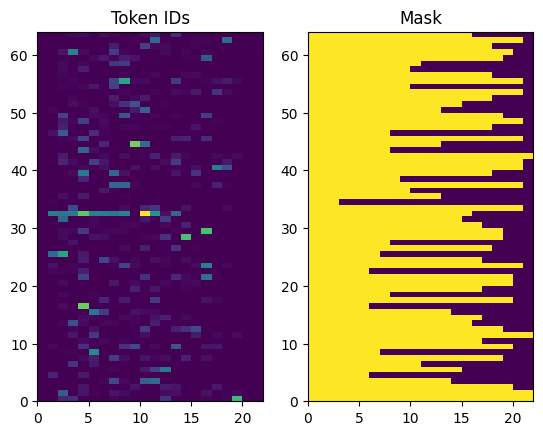

In [ ]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

In [ ]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)
train_ds.element_spec

((TensorSpec(shape=(None, None), dtype=tf.int64, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [ ]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy())
  print()
  print(ex_tar_in[0, :10].numpy())
  print(ex_tar_out[0, :10].numpy())

[   2  100  561  212 1384  679   10 3970    7    5]

[   2   95  447  119  324  680    9 3198 1013  352]
[  95  447  119  324  680    9 3198 1013  352 1180]


In [ ]:
UNITS = 256

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(self.units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

In [ ]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 22)
Encoder output, shape (batch, s, units): (64, 22, 256)


In [ ]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()

    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)

    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')

    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [ ]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (64, 22, 256)
Target sequence, shape (batch, t, units): (64, 20, 256)
Attention result, shape (batch, t, units): (64, 20, 256)
Attention weights, shape (batch, t, s):    (64, 20, 22)


In [ ]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([1.        , 0.99999994, 0.99999994, 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.99999994, 1.        ,
       1.        , 1.        , 1.0000001 , 1.0000001 , 1.0000001 ,
       1.0000001 , 1.0000001 , 1.0000001 , 1.0000001 , 1.0000001 ],
      dtype=float32)

Text(0.5, 1.0, 'Mask')

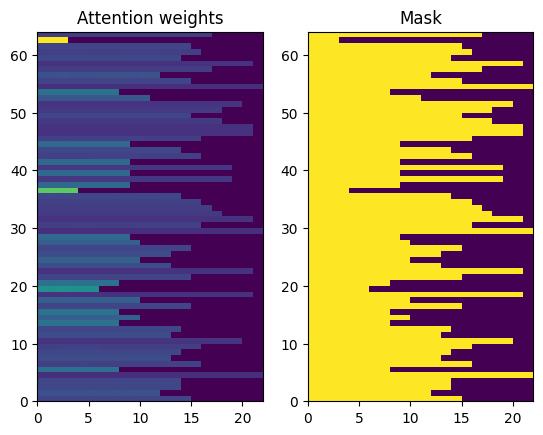

In [ ]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask')

In [ ]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

In [ ]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):
  shape_checker = ShapeChecker()
  shape_checker(x, 'batch t')
  shape_checker(context, 'batch s units')

  # 1. Lookup the embeddings
  x = self.embedding(x)
  shape_checker(x, 'batch t units')

  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)
  shape_checker(x, 'batch t units')

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
  shape_checker(x, 'batch t units')
  shape_checker(self.last_attention_weights, 'batch t s')

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)
  shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits

In [ ]:
decoder = Decoder(target_text_processor, UNITS)

In [ ]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 22, 256)
input target tokens shape: (batch, t) (64, 20)
logits shape shape: (batch, target_vocabulary_size) (64, 20, 14774)


In [ ]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [ ]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [ ]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True)

  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

  return next_token, done, state

In [ ]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'FRIDGE NIGEL STATESCOFFER YASSER CRISIS ABOVE DESC-GRAVITATIONAL INSTANCE COUNTRY DESC-FAST',
       b'PROLIFERATION DESC-FEDERAL LINATE DESC-BACKWARD FLEX NAUSEAM MA CMO LANDMARK WITHDEATH',
       b'FAITH DESC-INTERMITTENTLY ADVERSARY FINAL ODIHR RECONVERT VALUATION EVIDENCE ALLOWANCE COMPTE'],
      dtype=object)

In [ ]:

class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy.
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

In [ ]:
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 22)
Target tokens, shape: (batch, t) (64, 20)
logits, shape: (batch, t, target_vocabulary_size) (64, 20, 14774)


In [ ]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [ ]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [ ]:
model.compile(optimizer='adam',
              loss=masked_loss,
              metrics=[masked_acc, masked_loss])

In [ ]:
history = model.fit(
    train_ds.repeat(),
    epochs=100,
    steps_per_epoch = 80,
    validation_data=val_ds.repeat(),
    validation_steps = 30,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=4)])

Epoch 1/100
80/80 [==============================] - 56s 463ms/step - loss: 6.3489 - masked_acc: 0.1297 - masked_loss: 6.3489 - val_loss: 5.5535 - val_masked_acc: 0.2081 - val_masked_loss: 5.5535
Epoch 2/100
80/80 [==============================] - 17s 212ms/step - loss: 5.0811 - masked_acc: 0.2750 - masked_loss: 5.0811 - val_loss: 4.6295 - val_masked_acc: 0.3444 - val_masked_loss: 4.6295
Epoch 3/100
80/80 [==============================] - 18s 228ms/step - loss: 3.9442 - masked_acc: 0.4466 - masked_loss: 3.9442 - val_loss: 3.2852 - val_masked_acc: 0.5357 - val_masked_loss: 3.2852
Epoch 4/100
80/80 [==============================] - 11s 138ms/step - loss: 2.6001 - masked_acc: 0.6400 - masked_loss: 2.6001 - val_loss: 1.9312 - val_masked_acc: 0.7430 - val_masked_loss: 1.9312
Epoch 5/100
80/80 [==============================] - 11s 132ms/step - loss: 1.6846 - masked_acc: 0.7760 - masked_loss: 1.6846 - val_loss: 1.2850 - val_masked_acc: 0.8433 - val_masked_loss: 1.2850
Epoch 6/100
80/80 [=

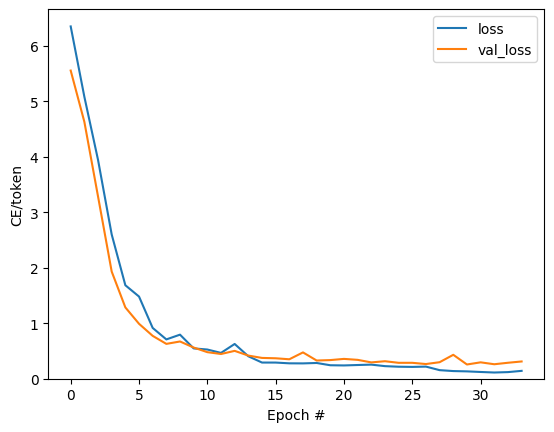

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

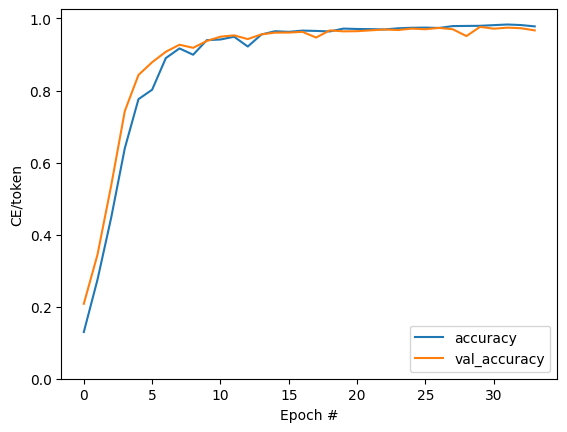

In [ ]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [ ]:
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)

    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

In [ ]:
inputs = [
    'What is your name ? ', # "NAME YOU WHAT"
    'I eat an apple ', # "EAT APPLE"
    'adjurnment of the session ' # "ADJOURNMENT SESSION"
]

In [ ]:
class Export(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
  def translate(self, inputs):
    return self.model.translate(inputs)

In [ ]:
export = Export(model)

In [ ]:
%%time
_ = export.translate(tf.constant(inputs))

CPU times: user 1min 24s, sys: 1.78 s, total: 1min 25s
Wall time: 1min 25s


In [ ]:
%%time
result = export.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

NAME BE X-YOU NAME ?                                             
EAT EAT BURDEN                                               
3POWER SESSION                                                

CPU times: user 154 ms, sys: 13.3 ms, total: 168 ms
Wall time: 265 ms


In [ ]:
%%time
tf.saved_model.save(export, 'translator',
                    signatures={'serving_default': export.translate})

CPU times: user 1min 45s, sys: 2.15 s, total: 1min 47s
Wall time: 1min 48s


In [ ]:
!ls

drive  sample_data


In [ ]:
!ls -l

total 8
drwx------ 5 root root 4096 Jul 12 15:51 drive
drwxr-xr-x 1 root root 4096 Jul 10 13:38 sample_data


In [ ]:
!file translator

translator: directory


In [ ]:
%cd ./drive/MyDrive/Translator

/content/drive/MyDrive/Translator


In [ ]:
!pwd

/content/drive/MyDrive/Translator


In [ ]:
!ls -l

total 4
drwx------ 4 root root 4096 Jul 12 16:04 translator


In [ ]:
%%time
reloaded = tf.saved_model.load('translator')
_ = reloaded.translate(tf.constant(inputs)) #warmup

CPU times: user 1min 25s, sys: 2.55 s, total: 1min 27s
Wall time: 1min 30s


In [ ]:
def translate(text, model=model):
  pred = model.translate([text.lower()])[0].numpy().decode()
  print("pred:", pred)

In [ ]:
translate("how are you", model=reloaded)

pred: HOW BE X-YOU                                               


In [ ]:
translate("i like sitting in parliament .")

pred: X-I LIKE SIT IN PARLIAMENT . 


In [ ]:
translate("adjournment of the session .")

pred: ADJOURNMENT SESSION . 


In [ ]:
translate("What is your name ?")

pred: WHAT BE X-YOU NAME ? 


In [ ]:
translate("i am grateful for all your speeches .")

pred: X-I BE DESC-GRATEFUL FOR ALL X-YOU SPEECH . 


In [ ]:
translate("madam prime minister , commissioner , I am delighted to see you here again today in america .")

pred: MADAM DESC-PRIME MINISTER , COMMISSIONER , X-I BE DESC-DELIGHTED TO SEE X-YOU DESC-HERE DESC-AGAIN TODAY IN AMERICA . 


In [ ]:
import socket
local_ip = socket.gethostbyname(socket.getfqdn(socket.gethostname()))
print(local_ip)

172.28.0.12


In [ ]:
import os, sys, requests, json
from multiprocessing import Process
from __future__ import print_function
from flask import Flask, request, abort, logging

app = Flask(__name__)

@app.route("/", methods=['GET', 'POST'])
def test():
    response = translate("how are you")
    print(request.args)
    return json.dumps({'response': response})

def stop_server():
  global server
  if server is not None:
    server.terminate()
    server.join()

def start_server(run_thread):
  global server
  if run_thread:
    server = Process(target=app.run, kwargs={'host':local_ip,'port':80})
    server.start()
  else:
    app.run(host=local_ip, port=80)

In [ ]:
run_thread = True
first_time = True
server = None

In [ ]:
print('hello')

hello


In [ ]:
stop_server()
start_server(run_thread)
run_thread = True

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://172.28.0.12:80
INFO:werkzeug:Press CTRL+C to quit


In [ ]:
!wget 172.28.0.12:80

--2023-07-12 07:21:52--  http://172.28.0.12/
Connecting to 172.28.0.12:80... failed: Connection refused.


In [ ]:
!ssh -o StrictHostKeyChecking=no -R 80:{local_ip}:80 serveo.net &

Pseudo-terminal will not be allocated because stdin is not a terminal.
Forwarding HTTP traffic from https://opus.serveo.net
HTTP request from 157.47.7.232 to https://opus.serveo.net/
HTTP request from 157.47.7.232 to https://opus.serveo.net/
connect_to 172.28.0.12 port 80: failed.
HTTP request from 157.47.7.232 to https://opus.serveo.net/
connect_to 172.28.0.12 port 80: failed.
HTTP request from 157.47.7.232 to https://opus.serveo.net/?lol=5
connect_to 172.28.0.12 port 80: failed.


KeyboardInterrupt: ignored

In [ ]:
r = requests.get()
print(r.text)
first_time = False

NameError: ignored

In [ ]:
if first_time:
  !pkill ssh